In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import wandb
import hydra
from omegaconf import DictConfig

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets,transforms 
from torch.utils.data.sampler import SubsetRandomSampler

import argparse
import time
import gc

import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data.distributed 
import torch.distributed as dist

# from utils.dataloaders import get_dataloader
# from utils.models import (get_model)
# from utils.optimizers import (get_optimizer)
# from utils.funcs import (progress_bar, start_timer, end_timer_and_print, reduce_tensor)

# wandb.login()
# os.environ['WANDB_SILENT']="true"

In [ ]:
local_arg_run = 0
loader = 'base'
batch_size = 128
workers = 0
arch = 'vit'
# optimizer = 'sgd'
lr = 0.0001
momentum = 0.9
weight_decay = 1e-4
nesterov = False
num_classes = 2
amp = False
local_rank = 0

In [ ]:
wandb.init(project="nsm_training")

In [ ]:
best_acc = 0
train_epoch = 0

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

In [ ]:
optim = False

## Dataloader

In [ ]:
#The mean and standard deviation of the ImageNet data Alexnet was trained on.
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225] 

In [ ]:
test_size = 0.30
random_seed = 24
num_workers = 0
batch_size = 8

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(256),    
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [ ]:
dataset_dir = "tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

train_dataset = datasets.ImageFolder(root=dataset_dir,
                                  transform=train_transform)

test_dataset = datasets.ImageFolder(root=dataset_dir,
                                  transform=test_transform)

In [ ]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_size * dataset_size))

In [ ]:
np.random.seed(random_seed)
np.random.shuffle(indices)

In [ ]:
train_idx, test_idx = indices[split:], indices[:split]

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          sampler=test_sampler,
                                          num_workers=num_workers)

In [ ]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

### Explore dataset
* Printing out a batch of train data and labels

In [ ]:
class_names = train_dataset.classes

print(class_names)

['Normal', 'Tuberculosis']


In [ ]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)  

In [ ]:
inputs, classes = next(iter(dataloaders['train']))

In [ ]:
out = torchvision.utils.make_grid(inputs)

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


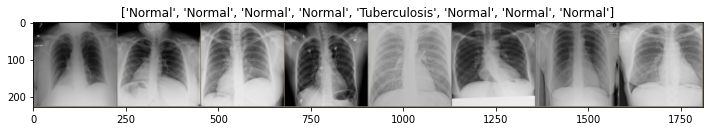

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
memory_format = (
        torch.channels_last if loader == 'gpu_optim' else torch.contiguous_format
)

## Model

In [ ]:
from torchvision import models

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs,512),
                    nn.ReLU(),
                    nn.Dropout(p=0.3),
                    nn.Linear(512,num_classes))

if optim:
    model = model.to(device, memory_format = memory_format)
else:
    model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
scaler = torch.cuda.amp.GradScaler(enabled=amp)

In [ ]:
def train(epoch):
        
    if local_arg_run == 0 or loader != 'parallel':
        print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device, memory_format = memory_format), targets.to(device)
        optimizer.zero_grad() 
        with torch.cuda.amp.autocast(enabled=amp, dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if local_arg_run == 0 or args.loader != 'parallel':
            wandb.log({'train_accuracy': 100.*correct/total, 'train_loss': train_loss/(batch_idx+1)})
#             progress_bar(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [ ]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device, memory_format = memory_format), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if local_arg_run == 0 or loader != 'parallel':
                wandb.log({'test_accuracy': 100.*correct/total, 'test_loss': test_loss/(batch_idx+1)})
#                 progress_bar(batch_idx, len(test_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    if local_arg_run == 0 or loader != 'parallel':
        acc = 100.*correct/total
        if acc > best_acc:
            state = {
                'model': model.state_dict(),
#                 'epoch': epoch,
            }
            if not os.path.isdir('saved_model'):
                os.mkdir('saved_model')
            torch.save(state, './saved_model/model_custom_resnet50.pt')
            best_acc = acc

In [ ]:
for epoch in range(train_epoch, train_epoch+3):
    train(epoch)
    test(epoch)


Epoch: 0
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torc